In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io
from astropy.stats.circstats import circcorrcoef
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from modelUtils import wrap_180, wrap_360, rot, scale_180_from_360, calc_sweep_times
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv
from deconv import poisson_of_release, sum_quanta

from SacNetwork import SacNetwork
# import balance_configs as configs
import sac_mode_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
# %matplotlib notebook
%matplotlib widget
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

# TODO:
**timing offsets between EI for each direction:**
- collect input locations for EI synapses at each rho level
- calculate the time delta between E and I
- how does this change over direction?

In [4]:
model_path = os.path.join(base_path, "sanity")
fig_path = os.path.join(model_path, "noise_figs") 
os.makedirs(fig_path, exist_ok=True)

dir_labels = np.array([225, 270, 315, 0, 45, 90, 135, 180])
circle = np.radians([0, 45, 90, 135, 180, 225, 270, 315, 0])
dir_rads = np.radians(dir_labels)
wrap_circ = lambda ds: np.concatenate((ds, [ds[0]]))
dirs_180 = np.array([ana.scale_180_from_360(d) for d in dir_labels])
dir_sort = np.argsort(dir_labels)
dir_180_sort = np.argsort(dirs_180)
dirs_sorted = dir_labels[dir_sort]
dirs_180_sorted = dirs_180[dir_sort]
circ_180 = np.concatenate((dirs_180_sorted, [-dirs_180_sorted[0]]))

# conf = configs.sac_mode_config()
conf = configs.decr_weight()
probs = {
    t: {
        "null": conf["synprops"][t]["null_prob"],
        "pref": conf["synprops"][t]["pref_prob"],
    }
    for t in ["E", "I"]
}
conf["sac_uniform_dist"] = {0: False, 1: False}  # unused dummy value
conf["sac_shared_var"] = 30  # unused dummy value
conf["sac_theta_vars"] = {"E": 60, "I": 60}  # unused dummy value
conf["sac_theta_mode"] = "experimental"  # used (supercedes above settings)

rng = np.random.default_rng()

In [5]:
quanta_h5 = "/mnt/Data/prerna_velocity/static_roi_waveforms/quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
release_rates = quantum_pack["clipped_rates"]
rec_dt = quantum_pack["rec_dt"]
target_rate_dt = 0.001  # 0.0001
bp_inputs = {("sust" if k == "PD" else "trans"): r for k, r in quantum_pack["aligned_recs"].items()}
bp_inputs["sust"] = bp_inputs["sust"] * np.max(bp_inputs["trans"]) / np.max(bp_inputs["sust"])

vrate = deconv.velocity_rate(
    bp_inputs["trans"],
    rec_dt,
    quantum_pack["quantum"],
    1,
    rf=0.06,
    spot=0.2,
    bsln_start=100,
    bsln_end=150,
    step=1,
    offset=0.,
    model_dt=target_rate_dt,
)
vrate = np.clip(vrate, 0.0, np.inf)
vrate /= np.max(vrate)  # recently added, this is done before giving to the neuron model
vrate_pts = len(vrate)
vrate_xaxis = np.arange(vrate_pts)

Text(0.5, 0, 'Time (ms)')

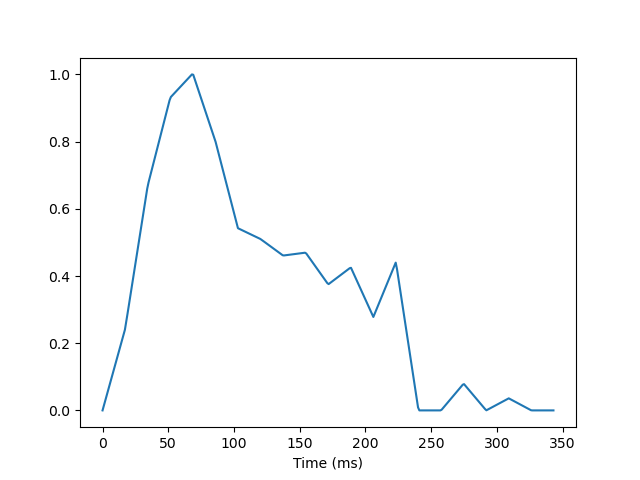

In [6]:
vrate_fig, vrate_ax = plt.subplots(1)
vrate_ax.plot(vrate_xaxis, vrate)
vrate_ax.set_xlabel("Time (ms)")

### Correlated Poisson train generation using a shared base

In [7]:
def poisson_shared_base(rng, rate, rho=0.8, i_scale=1, e_scale=0.8):
    inv_rho = 1 - rho
    # inv_rho = 1 - rho**2
    # inv_rho = np.sqrt(1 - rho**2)
    base_psn = poisson_of_release(rng, rate * rho)
    e_psn = np.round(
        e_scale * (base_psn + poisson_of_release(rng, rate * inv_rho))
    ).astype(int)
    i_psn = np.round(
        i_scale * (base_psn + poisson_of_release(rng, rate * inv_rho))
    ).astype(int)
    return base_psn, e_psn, i_psn
    
def poisson_correlation_shared_base(rate, i_scale=1, e_scale=0.8):
    rng = np.random.default_rng()
    base_total, e_total, i_total, corr = [], [], [], []
    for _ in range(10000):
        base_psn, e_psn, i_psn = poisson_shared_base(rng, rate, rho=0.8, i_scale=i_scale, e_scale=e_scale)
        base_total.append(np.sum(base_psn))
        i_total.append(np.sum(i_psn))
        e_total.append(np.sum(e_psn))
        corr.append(np.corrcoef(i_psn - rate * i_scale, e_psn - rate * e_scale)[0][1])

    print(
        "base total = %f\ni total = %f\ne total = %f\n corr = %f\n"
        % (np.mean(base_total), np.mean(i_total), np.mean(e_total), np.mean(corr))
    )
poisson_correlation_shared_base(vrate)

base total = 99.926500
i total = 124.862500
e total = 119.638500
 corr = 0.783337



### Correlated Poisson train generation using one train as the base of the other

In [8]:
def poisson_correlation_inhib_base(rate):
    rng = np.random.default_rng()
    rho = 0.6
    inv_rho = 1 - rho
    # inv_rho = 1 - rho**2
    # inv_rho = np.sqrt(1 - rho**2)
    # scale = 0.6
    scale = 1
    e_total, i_total, corr = [], [], []
    for _ in range(10000):
        i_psn = poisson_of_release(rng, rate)
        e_psn = np.round(
            scale * (i_psn * rho + poisson_of_release(rng, rate * inv_rho))
        ).astype(int)
        i_psn = np.round(scale * i_psn).astype(int)

        i_total.append(np.sum(i_psn))
        e_total.append(np.sum(e_psn))
        # corr.append(np.corrcoef(i_psn, e_psn)[0][1])
        corr.append(np.corrcoef(i_psn - np.mean(i_psn), e_psn - np.mean(e_psn))[0][1])

    print(
        "i total = %f\ne total = %f\n corr = %f\n"
        % (np.mean(i_total), np.mean(e_total), np.mean(corr))
    )
    
poisson_correlation_inhib_base(vrate)

i total = 124.618700
e total = 149.171200
 corr = 0.764422



### Generating correlated normal distributions

mvar corr: [[1.         0.80784298]
 [0.80784298 1.        ]]


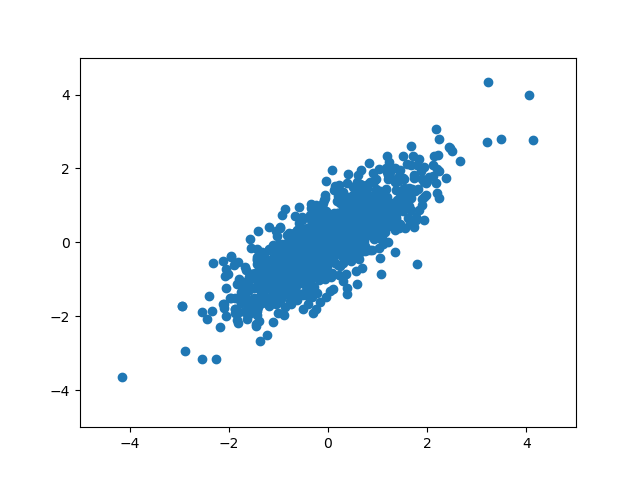

In [9]:
mvar_rho = 0.8
cov = np.array([[1, mvar_rho], [mvar_rho, 1]])
mvar = rng.multivariate_normal(np.zeros(2), cov, size=1000)
def mvar_fun(size):
    """Multivariate normal distribution with covariance matrix baked in."""
    return rng.multivariate_normal(np.zeros(2), cov, size=size)

def mvar_dumb(size):
    """Stationary pre-generated correlated values for sanity checking."""
    return mvar

def mvar_dumb_half(size):
    """Stationary pre-generated correlated values for sanity checking."""
    return mvar * 0.5

mvar_fig, mvar_ax = plt.subplots(1)
mvar_ax.scatter(mvar[:, 0], mvar[:, 1])
mvar_ax.set_xlim(-5, 5)
mvar_ax.set_ylim(-5, 5)
print("mvar corr:", np.corrcoef(mvar[:, 0], mvar[:, 1]))

### Generating 3 or more correlated normal distributions
Basic demonstration of constructing a covariance matrix for more than 2 distributions and
using `multivariate_normal` to sample from them.

This is used to correlate the noise of plexus dendrites as well.
Falloff of correlation should follow the same angular delta rule as EI correlations have been.

ab corr: 0.8932361098564382
bc corr: 0.5812411543464998
ac corr: 0.25476963554952936


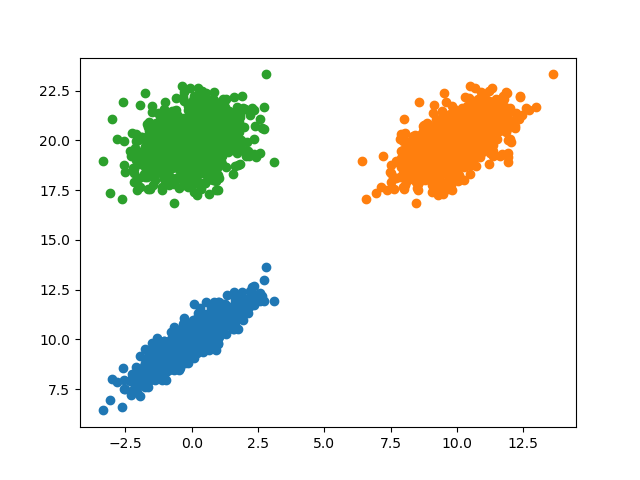

In [10]:
ab = 0.9
bc = 0.6
ac = 0.3
# ab = 0.8
# bc = 0.4
# ac = 0.0
cov3 = np.array(
    [[1, ab, ac], 
     [ab, 1, bc],
     [ac, bc, 1]])
# mvar3 = rng.multivariate_normal(np.zeros(3), cov3, size=1000)
mvar3 = rng.multivariate_normal([0, 10, 20], cov3, size=1000)

mvar3_fig, mvar3_ax = plt.subplots(1)
mvar3_ax.scatter(mvar3[:, 0], mvar3[:, 1])
mvar3_ax.scatter(mvar3[:, 1], mvar3[:, 2])
mvar3_ax.scatter(mvar3[:, 0], mvar3[:, 2])

print("ab corr:", np.corrcoef(mvar3[:, 0], mvar3[:, 1])[0, 1])
print("bc corr:", np.corrcoef(mvar3[:, 1], mvar3[:, 2])[0, 1])
print("ac corr:", np.corrcoef(mvar3[:, 0], mvar3[:, 2])[0, 1])

Innovations or "state_shocks"
[used in this correlated AR(p) time-series example](https://stats.stackexchange.com/questions/136291/how-do-you-simulate-two-correlated-arp-time-series)
[leveraging R's arima](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/arima.sim) seem to be the 
equivalent of the distrvs param of `ArmaProcess.generate_sample`

Input variance scaling equivalent to post-process scaling: True
arma corrcoef (mvar rho 0.8): 0.780438


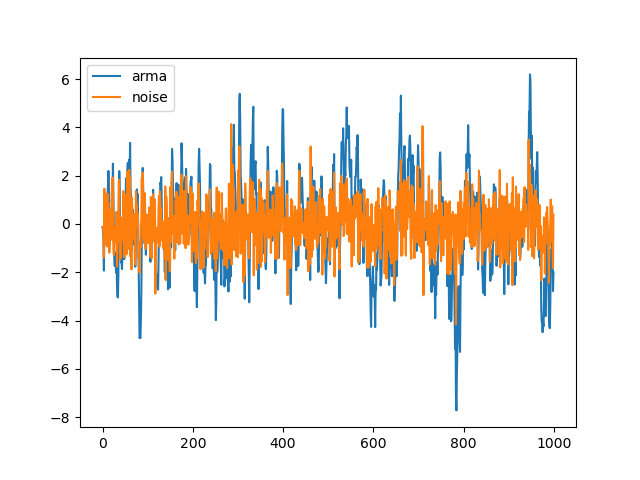

In [11]:
# arparams = np.array([.75, -.25])
# maparams = np.array([.65, .355])

# arparams = np.array([0.8])
# maparams = np.array([0])

arparams = np.array([0.9, -0.1])
maparams = np.array([0])

# arparams = np.array([0.])
# maparams = np.array([0.8])

ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag

arma_process = sm.tsa.ArmaProcess(ar, ma)
# ss = arma_process.generate_sample(1000, distrvs=mvar_fun)
ss = arma_process.generate_sample(1000, distrvs=mvar_dumb)

pre_halved = arma_process.generate_sample(10, distrvs=mvar_dumb_half)
post_halved = arma_process.generate_sample(10, distrvs=mvar_dumb) * 0.5
print("Input variance scaling equivalent to post-process scaling:", (pre_halved == post_halved).all())

arma_fig, arma_ax = plt.subplots(1)
arma_ax.plot(ss[:, 0], label="arma")
# arma_ax.plot(ss[:, 1])
arma_ax.plot(mvar[:, 0], label="noise")
arma_ax.legend()
print("arma corrcoef (mvar rho %s): %f" % (str(mvar_rho), np.corrcoef(ss[:, 0], ss[:, 1])[0, 1]))

### Rolling averages of noise innovations vs the ARMA
This demonstrates nicely that the ARMA is itself a rolling process that is incorporating the noise
into it's state at each step. The noise amplitude is reduced much more by the rolling average since neighbouring points are independent from eachother.

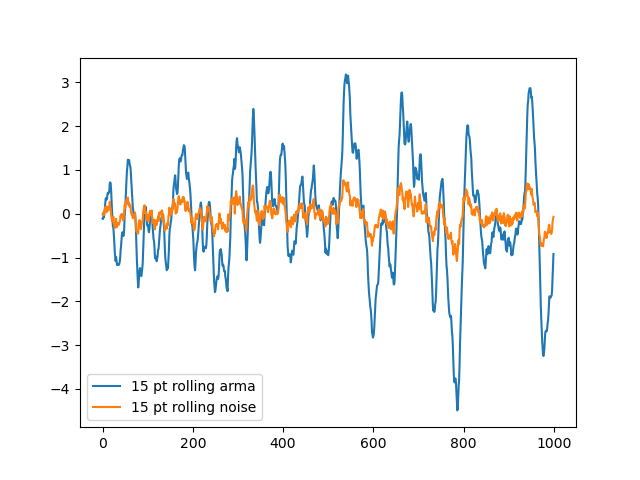

In [12]:
window = 15
roll_fig, roll_ax = plt.subplots(1)
roll_ax.plot(rolling_average(ss[:, 0], n=window), label="%i pt rolling arma" % window)
roll_ax.plot(rolling_average(mvar[:, 0], n=window), label="%i pt rolling noise" % window)
roll_ax.legend()

### Scaling ARMA innovations (distrvs) by release template to create noisey release rate transient

corrcoef: 0.7975391174392825
clipped corrcoef: 0.7975391174392825


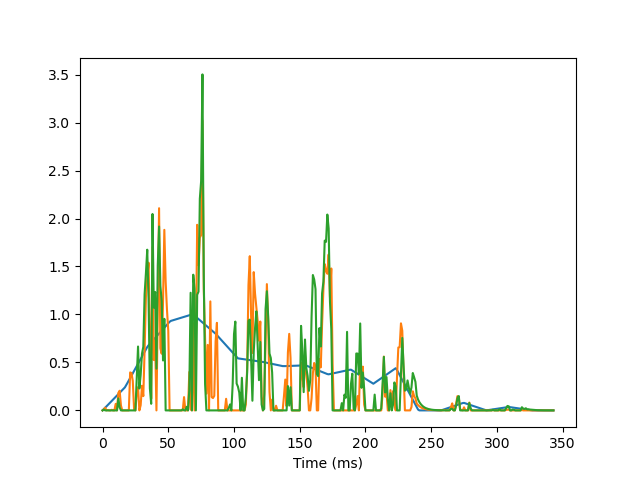

In [13]:
norm_rate = vrate / np.max(vrate)

def rate_mvar_fun(cov, rate, factor, rng=rng):
    scale = rate.reshape(-1, 1) * factor
    def fun(size):
        return rng.multivariate_normal(np.zeros(2), cov, size=size) * scale
    return fun

# arparams = np.array([.75, -.25])
# maparams = np.array([.65, .355])

arparams = np.array([0.9, -0.1])
maparams = np.array([0.])

# arparams = np.array([0.])
# maparams = np.array([0.9])
# maparams = np.array([0.65, 0.355])

# arparams = np.array([.6, .3])
# maparams = np.array([0, 0])

ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag

innov_scale = 1
arma_process = sm.tsa.ArmaProcess(ar, ma)
ss = arma_process.generate_sample(len(norm_rate), distrvs=rate_mvar_fun(cov, norm_rate, innov_scale))

arma_rate_fig, arma_rate_ax = plt.subplots(1)
arma_rate_ax.plot(vrate_xaxis, norm_rate)
# arma_rate_ax.plot(norm_rate + ss[:, 0])
# arma_rate_ax.plot(norm_rate + ss[:, 1])
# arma_rate_ax.plot(np.clip(norm_rate + ss[:, 0], 0, np.inf))
# arma_rate_ax.plot(np.clip(norm_rate + ss[:, 1], 0, np.inf))
arma_rate_ax.plot(vrate_xaxis, np.clip(ss[:, 0], 0, np.inf))
arma_rate_ax.plot(vrate_xaxis, np.clip(ss[:, 1], 0, np.inf))
arma_rate_ax.set_xlabel("Time (ms)")
# arma_rate_ax.legend()
css = np.clip(ss, 0, np.inf)
print("corrcoef:", np.corrcoef(css[:, 0], css[:, 1])[0, 1])
print("clipped corrcoef:", np.corrcoef(css[:, 0], css[:, 1])[0, 1])

### Convolving release rate with biexponential quanta

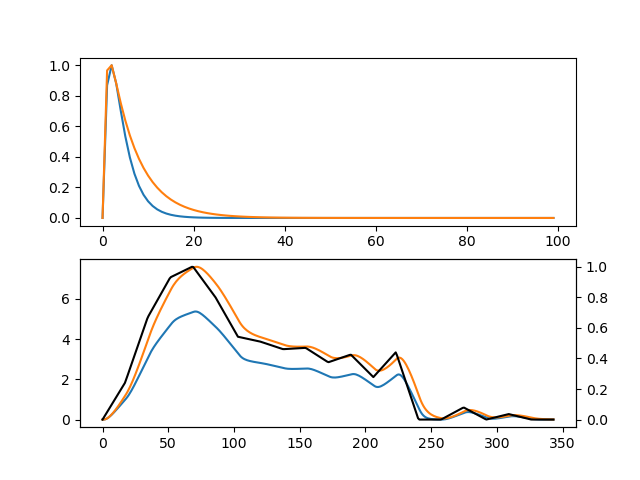

In [14]:
# quanta_xaxis = np.linspace(0, 0.50, 100)
quanta_xaxis = np.arange(100)

ach_biexp = biexp(quanta_xaxis, 1.2, 3, m=1, b=0)
ach_biexp /= np.min(ach_biexp)
gaba_biexp = biexp(quanta_xaxis, 0.6, 6, m=1, b=0)
gaba_biexp /= np.min(gaba_biexp)

ach_ex = np.convolve(norm_rate, ach_biexp, mode="full")[:len(norm_rate)]
gaba_ex = np.convolve(norm_rate, gaba_biexp, mode="full")[:len(norm_rate)]
# ach_ex = np.convolve(norm_rate, np.flip(ach_biexp), mode="same")
# gaba_ex = np.convolve(norm_rate, np.flip(gaba_biexp), mode="same")

trans_ex_fig, trans_ex_ax = plt.subplots(2)
trans_ex_ax[0].plot(quanta_xaxis, ach_biexp)
trans_ex_ax[0].plot(quanta_xaxis, gaba_biexp)
trans_ex_axr = trans_ex_ax[1].twinx()
trans_ex_axr.plot(vrate, color="black")
trans_ex_ax[1].plot(ach_ex)
# trans_ex_ax[1].plot(ach_ex / np.max(ach_ex) * np.max(gaba_ex))
trans_ex_ax[1].plot(gaba_ex)

### Release rate template with addition of release scaled correlated ARMA

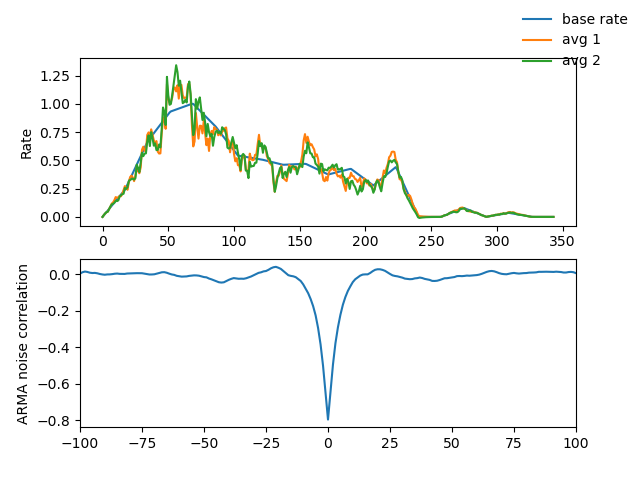

In [15]:
base_scale = 1
n_trials = 100
recs = np.zeros((n_trials, 2, len(norm_rate)))
xcorrs = np.zeros((n_trials, len(norm_rate) * 2 - 1))
for i in range(n_trials):
    noise = arma_process.generate_sample(len(norm_rate), distrvs=rate_mvar_fun(cov, norm_rate, innov_scale))
    recs[i] = base_scale * norm_rate + noise.T
    xcorrs[i] = norm_xcorr(noise[:, 0], noise[:, 1] * -1, mode="full")

avg_recs = np.mean(recs, axis=0)
full_xaxis = np.concatenate([np.flip(vrate_xaxis[1:] * -1), vrate_xaxis])

arma_avg_rate_fig, arma_avg_rate_ax = plt.subplots(2)
arma_avg_rate_ax[0].plot(norm_rate, label="base rate")
arma_avg_rate_ax[0].plot(avg_recs[0], label="avg 1")
arma_avg_rate_ax[0].plot(avg_recs[1], label="avg 2")
arma_avg_rate_ax[1].plot(full_xaxis, np.mean(xcorrs, axis=0))
arma_avg_rate_ax[0].set_ylabel("Rate")
arma_avg_rate_ax[1].set_ylabel("ARMA noise correlation")

arma_avg_rate_ax[1].set_xlim(-100, 100)
arma_avg_rate_fig.legend(frameon=False)

### Quantal sums of Poisson trains generated from ARMA generated release rates

**New direction:**
Spoke to Gautam and have a new plan for the figure based on this. The release rate / poisson will be corresponding to a particular synapse in the ball and stick schematics (null direction) of corelease and uncorrelated. This will help depict the temporal offset and differences in correlation / pre-synaptic 
noise. For the circled uncorr synapse, it's about 74 degrees off, which means (1 - 74/180 = .59 rho) correlation, and ~23ms delayed onset of excitation relative to inhibition. Since the inhibition is the same in each, having the xaxis start relative to that should be fine.

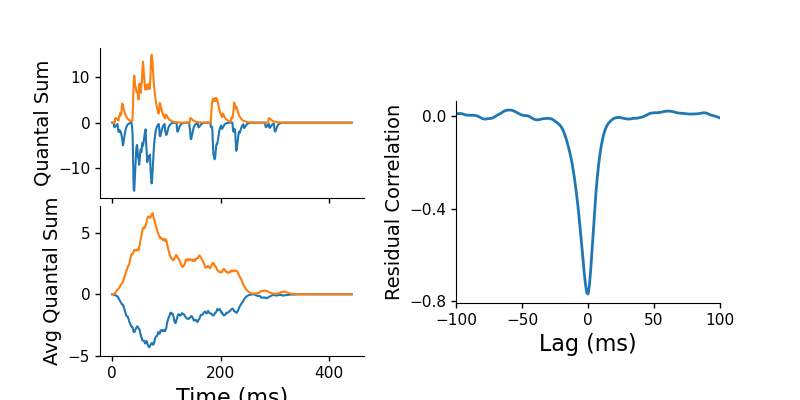

In [16]:
# TODO
# get rid of pref/null distinction, only doing "null" now which is preferred for the e/i synapse pair,
# a null corelease synapse.
# separate scaling for e/i release rate for uncorr (corelease has same, going to use a syn that is full)
# onset time shift on the uncorr one (corelease is same)
corr_ei_rho = 1
uncorr_ei_rho = 0
pref_ei_ratio = 1
null_ei_ratio = 3
seed = 2
tr = 0  # trial to display
n_trials = 100

dt = 1
corr_ei_cov = np.array([[1, corr_ei_rho], [corr_ei_rho, 1]])
uncorr_ei_cov = np.array([[1, uncorr_ei_rho], [uncorr_ei_rho, 1]])
rng = np.random.default_rng(seed)
dummy_psn = poisson_of_release(rng, vrate)
dummy_qsum = sum_quanta(dummy_psn, np.arange(len(dummy_psn)) * dt, ach_biexp, dt)

arma_mode = True
base_scale = 0
innov_scale = 1.
arparams = np.array([0.9, -0.1])
# arparams = np.array([0.95, -0.1])
maparams = np.array([0.])

# arparams = np.array([.75, -.25])
# maparams = np.array([.65, .355])
# arparams = np.array([0])
# maparams = np.array([0.9])

ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
arma_process = sm.tsa.ArmaProcess(ar, ma)

# ach_biexp = biexp(quanta_xaxis, 0.14 , 0.54, m=1, b=0)
ach_biexp = biexp(quanta_xaxis, 1.2 , 3, m=1, b=0)
# gaba_biexp = biexp(quanta_xaxis, 0.14, 2, m=1, b=0)
gaba_biexp = biexp(quanta_xaxis, 0.6, 6, m=1, b=0)
ach_biexp /= np.min(ach_biexp)
gaba_biexp /= np.min(gaba_biexp)

# shapes: (pref (0) / null (1), corr (0) / uncorr (1), n_trials, e (0) / i (1), pts)
qsum_recs = np.zeros((2, 2, n_trials, 2, len(dummy_qsum)))
qsum_xcorrs = np.zeros((2, 2, n_trials, len(dummy_qsum) * 2 - 1))
rates = np.zeros((2, 2, n_trials, 2, vrate_pts))
qsum_xaxis = np.arange(len(dummy_qsum)) * dt
psns = np.zeros((2, 2, n_trials, 2, vrate_pts))

for d, mul in enumerate([pref_ei_ratio, null_ei_ratio]):
    for r, ei_cov in enumerate([corr_ei_cov, uncorr_ei_cov]):  
        for i in range(n_trials):
            if arma_mode:
                noise = arma_process.generate_sample(
                    vrate_pts, distrvs=rate_mvar_fun(ei_cov, norm_rate, innov_scale, rng=rng))
                ach_rate = base_scale * norm_rate + noise[:, 0]
                gaba_rate = (base_scale * norm_rate + noise[:, 1]) * mul
                rates[d, r, i, 0], rates[d, r, i, 1] = ach_rate, gaba_rate
                psns[d, r, i, 0, :] = poisson_of_release(rng, ach_rate)
                psns[d, r, i, 1, :] = poisson_of_release(rng, gaba_rate)
            else:
                _, psns[d, r, i, 0, :], psns[i, 1, :] = poisson_shared_base(
                    rng, vrate, rho=0.9, i_scale=mul, e_scale=1)
            qsum_recs[d, r, i, 0] = sum_quanta(psns[d, r, i, 0], np.arange(vrate_pts) * dt, ach_biexp, dt) * -1
            qsum_recs[d, r, i, 1] = sum_quanta(psns[d, r, i, 1], np.arange(vrate_pts) * dt, gaba_biexp, dt)

pos_rates = np.clip(rates, 0, None) 
avg_qsum_recs = np.mean(qsum_recs, axis=2)
qsum_rec_resid = qsum_recs - np.expand_dims(avg_qsum_recs, 2)
for d in range(2):
    for r in range(2):
        for i in range(n_trials):
             qsum_xcorrs[d, r, i] = norm_xcorr(qsum_rec_resid[d, r, i, 0], qsum_rec_resid[d, r, i, 1], mode="full")
        
avg_qsum_xcorr = np.mean(qsum_xcorrs, axis=2)

# what to display
d = 0  # pref (0) / null (1)
r = 0  # corr (0) / uncorr (1)

full_qsum_xaxis = np.concatenate([np.flip(qsum_xaxis[1:] * -1), qsum_xaxis])
# poisson_qsum_fig, poisson_qsum_ax = plt.subplots(3, figsize=(6, 8))
poisson_qsum_fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(6, 2, wspace=0.35)
poisson_qsum_ax = [
    poisson_qsum_fig.add_subplot(gs[0:3, 0]),
    poisson_qsum_fig.add_subplot(gs[3:, 0]),
    poisson_qsum_fig.add_subplot(gs[1:5, 1]),
]
poisson_qsum_ax[1].sharex(poisson_qsum_ax[0])
poisson_qsum_ax[0].plot(qsum_xaxis, qsum_recs[d, r, 0, 0], lw=1.5)
poisson_qsum_ax[0].plot(qsum_xaxis, qsum_recs[d, r, 0, 1], lw=1.5)
poisson_qsum_ax[1].plot(qsum_xaxis, avg_qsum_recs[d, r, 0], lw=1.5)
poisson_qsum_ax[1].plot(qsum_xaxis, avg_qsum_recs[d, r, 1], lw=1.5)
poisson_qsum_ax[2].plot(full_qsum_xaxis, avg_qsum_xcorr[d, r], lw=2)
poisson_qsum_ax[1].set_xticks([0, 200, 400])
poisson_qsum_ax[1].set_yticks([-5, 0, 5])
# poisson_qsum_ax[0].set_xticklabels([None] * 3)
plt.setp(poisson_qsum_ax[0].get_xticklabels(), visible=False)
poisson_qsum_ax[2].set_xlim(-100, 100)
poisson_qsum_ax[2].set_yticks([-0.8, -0.4, 0])
poisson_qsum_ax[0].set_ylabel("Quantal Sum", fontsize=14)
poisson_qsum_ax[1].set_ylabel("Avg Quantal Sum", fontsize=14)
poisson_qsum_ax[2].set_ylabel("Residual Correlation", fontsize=14)
poisson_qsum_ax[1].set_xlabel("Time (ms)", fontsize=16)
poisson_qsum_ax[2].set_xlabel("Lag (ms)", fontsize=16)

clean_axes(poisson_qsum_ax)
# poisson_qsum_fig.set_layout_engine("compressed")

rho_lbl = str(corr_ei_rho if r == 0 else uncorr_ei_rho)
dir_lbl = "pref" if d == 0 else "null"
for ext in [".png", ".svg"]:
    poisson_qsum_fig.savefig(
        os.path.join(fig_path, "poisson_qsum_rho%s_%s_seed%i_trial%iof%i%s" % (
            rho_lbl, dir_lbl, seed, tr, n_trials, ext)), bbox_inches="tight")

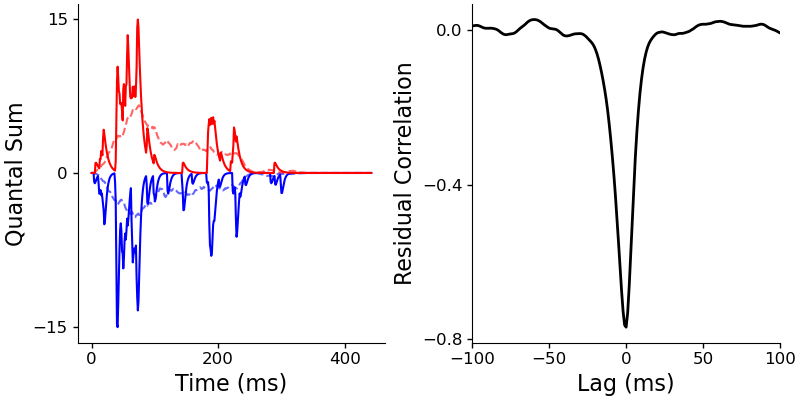

In [17]:
d = 0  # pref (0) / null (1)
r = 0  # corr (0) / uncorr (1)
tr = 0  # trial to display

poisson_qsum_overlay_fig, poisson_qsum_overlay_ax = plt.subplots(1, 2, figsize=(8, 4))
poisson_qsum_overlay_ax[0].plot(qsum_xaxis, avg_qsum_recs[d, r, 0], c="blue", lw=1.5, alpha=0.6, linestyle="--")
poisson_qsum_overlay_ax[0].plot(qsum_xaxis, avg_qsum_recs[d, r, 1], c="red", lw=1.5, alpha=0.6, linestyle="--")
poisson_qsum_overlay_ax[0].plot(qsum_xaxis, qsum_recs[d, r, tr, 0], c="blue", lw=1.5)
poisson_qsum_overlay_ax[0].plot(qsum_xaxis, qsum_recs[d, r, tr, 1], c="red", lw=1.5)
poisson_qsum_overlay_ax[1].plot(full_qsum_xaxis, avg_qsum_xcorr[d, r], c="black", lw=2)
poisson_qsum_overlay_ax[0].set_xticks([0, 200, 400])
poisson_qsum_overlay_ax[0].set_yticks([-15, 0, 15])
poisson_qsum_overlay_ax[1].set_xlim(-100, 100)
poisson_qsum_overlay_ax[1].set_yticks([-0.8, -0.4, 0])
poisson_qsum_overlay_ax[0].set_ylabel("Quantal Sum", fontsize=16)
poisson_qsum_overlay_ax[1].set_ylabel("Residual Correlation", fontsize=16)
poisson_qsum_overlay_ax[0].set_xlabel("Time (ms)", fontsize=16)
poisson_qsum_overlay_ax[1].set_xlabel("Lag (ms)", fontsize=16)

clean_axes(poisson_qsum_overlay_ax,ticksize=12)
poisson_qsum_overlay_fig.set_layout_engine("compressed")

rho_lbl = str(corr_ei_rho if r == 0 else uncorr_ei_rho)
dir_lbl = "pref" if d == 0 else "null"
for ext in [".png", ".svg"]:
    poisson_qsum_overlay_fig.savefig(
        os.path.join(fig_path, "poisson_qsum_overlay_rho%s_%s_seed%i_trial%iof%i%s" % (
            rho_lbl, dir_lbl, seed, tr, n_trials, ext)), bbox_inches="tight")

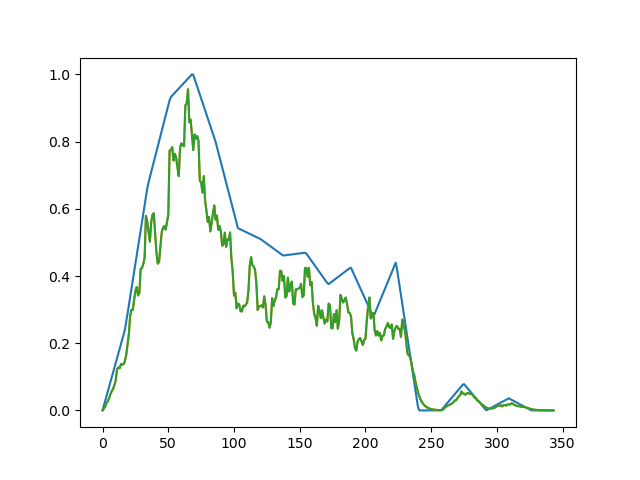

In [18]:
d = 0  # pref (0) / null (1)
r = 0  # corr (0) / uncorr (1)

avg_pos_rates = np.mean(pos_rates, axis=2)
avg_pos_rates_fig, avg_pos_rates_ax = plt.subplots(1)
avg_pos_rates_ax.plot(vrate_xaxis, norm_rate)
avg_pos_rates_ax.plot(vrate_xaxis, avg_pos_rates[d, r, 0])
avg_pos_rates_ax.plot(vrate_xaxis, avg_pos_rates[d, r, 1])

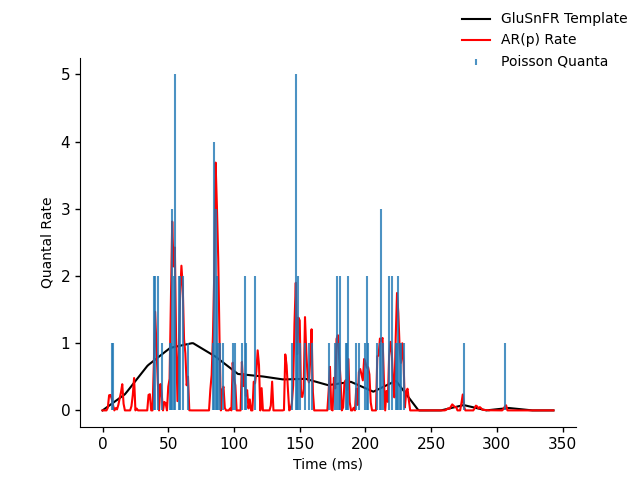

In [19]:
twin_mode = False
seed = 14
rng = np.random.default_rng(seed)
noise = arma_process.generate_sample(
    len(norm_rate), distrvs=rate_mvar_fun(ei_cov, norm_rate, innov_scale, rng=rng))
nz_rate = base_scale * norm_rate + noise[:, 0] 
pos_nz_rate = np.clip(nz_rate, 0, None)
nz_psn = poisson_of_release(rng, pos_nz_rate)

poisson_ex_fig, poisson_ex_ax = plt.subplots(1)
psn_ex_quanta_ax = poisson_ex_ax.twinx() if twin_mode else poisson_ex_ax
poisson_ex_ax.plot(vrate_xaxis, norm_rate, c="black", label="GluSnFR Template")
poisson_ex_ax.plot(vrate_xaxis, pos_nz_rate, c="red", label="AR(p) Rate")
_, nz_psn_stems, _ = psn_ex_quanta_ax.stem(
    vrate_xaxis,
    nz_psn,
    linefmt="-",
    markerfmt="none",
    basefmt="none",
    label="Poisson Quanta",
)
nz_psn_stems.set_alpha(0.8)

poisson_ex_ax.set_ylabel("Quantal Rate")
if twin_mode: psn_ex_quanta_ax.set_ylabel("Quanta")
poisson_ex_ax.set_xlabel("Time (ms)")
clean_axes(poisson_ex_ax)

poisson_ex_fig.legend(frameon=False)

for ext in [".png", ".svg"]:
    poisson_ex_fig.savefig(
        os.path.join(fig_path, "arma_poisson_ex_seed%i%s" % (seed, ext)), bbox_inches="tight")

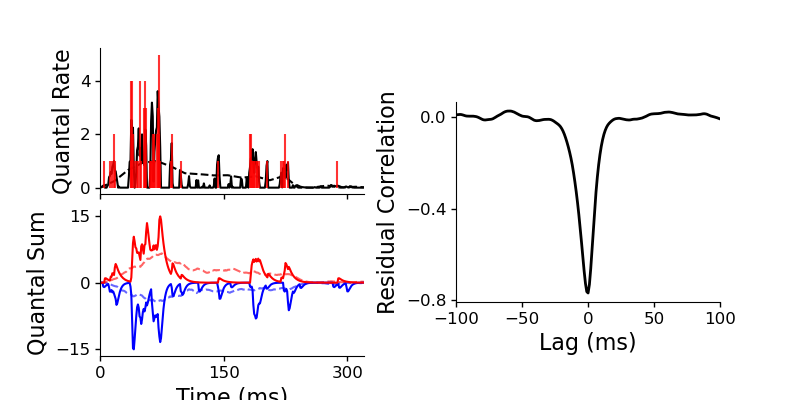

In [20]:
d = 0  # pref (0) / null (1)
r = 0  # corr (0) / uncorr (1)
tr = 0  # trial to display

poisson_rate_and_qsum_fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(6, 2, hspace=0.4, wspace=0.35)
poisson_rate_and_qsum_ax = [
    poisson_rate_and_qsum_fig.add_subplot(gs[0:3, 0]),
    poisson_rate_and_qsum_fig.add_subplot(gs[3:, 0]),
    poisson_rate_and_qsum_fig.add_subplot(gs[1:5, 1]),
]
poisson_rate_and_qsum_ax[0].sharex(poisson_rate_and_qsum_ax[1])
plt.setp(poisson_rate_and_qsum_ax[0].get_xticklabels(), visible=False)

poisson_rate_and_qsum_ax[0].plot(vrate_xaxis, norm_rate, c="black", ls="--", label="iGluSnFR Template")
poisson_rate_and_qsum_ax[0].plot(vrate_xaxis, np.clip(rates[d, r, tr, 1], 0, None), c="black", label="AR(p) Rate")
_, nz_psn_stems, _ = poisson_rate_and_qsum_ax[0].stem(
    vrate_xaxis,
    psns[d, r, tr, 1],
    linefmt="-",
    markerfmt="none",
    basefmt="none",
    label="Poisson Quanta",
)
nz_psn_stems.set_alpha(0.8)
# nz_psn_stems.set_edgecolor("purple")
# nz_psn_stems.set_facecolor("none")
nz_psn_stems.set_color("red")

poisson_rate_and_qsum_ax[1].plot(qsum_xaxis, avg_qsum_recs[d, r, 0], c="blue", lw=1.5, alpha=0.6, linestyle="--")
poisson_rate_and_qsum_ax[1].plot(qsum_xaxis, avg_qsum_recs[d, r, 1], c="red", lw=1.5, alpha=0.6, linestyle="--")
poisson_rate_and_qsum_ax[1].plot(qsum_xaxis, qsum_recs[d, r, tr, 0], c="blue", lw=1.5)
poisson_rate_and_qsum_ax[1].plot(qsum_xaxis, qsum_recs[d, r, tr, 1], c="red", lw=1.5)
poisson_rate_and_qsum_ax[2].plot(full_qsum_xaxis, avg_qsum_xcorr[d, r], c="black", lw=2)

poisson_rate_and_qsum_ax[0].set_yticks([0, 2, 4])
poisson_rate_and_qsum_ax[1].set_xlim(0, 320)
poisson_rate_and_qsum_ax[1].set_xticks([0, 150, 300])
poisson_rate_and_qsum_ax[1].set_yticks([-15, 0, 15])
poisson_rate_and_qsum_ax[2].set_xlim(-100, 100)
poisson_rate_and_qsum_ax[2].set_yticks([-0.8, -0.4, 0])

poisson_rate_and_qsum_ax[0].set_ylabel("Quantal Rate", fontsize=16)
poisson_rate_and_qsum_ax[1].set_ylabel("Quantal Sum", fontsize=16)
poisson_rate_and_qsum_ax[2].set_ylabel("Residual Correlation", fontsize=16)
poisson_rate_and_qsum_ax[1].set_xlabel("Time (ms)", fontsize=16)
poisson_rate_and_qsum_ax[2].set_xlabel("Lag (ms)", fontsize=16)

clean_axes(poisson_rate_and_qsum_ax, ticksize=12)

rho_lbl = str(corr_ei_rho if r == 0 else uncorr_ei_rho)
dir_lbl = "pref" if d == 0 else "null"
for ext in [".png", ".svg"]:
    poisson_rate_and_qsum_fig.savefig(
        os.path.join(fig_path, "poisson_rate_qsum_overlay_rho%s_%s_seed%i_trial%iof%i%s" % (
            rho_lbl, dir_lbl, seed, tr, n_trials, ext)), bbox_inches="tight")

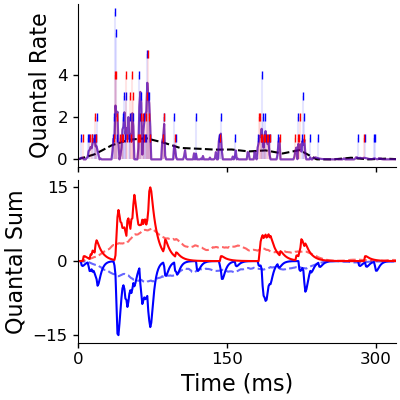

In [21]:
d = 0  # pref (0) / null (1)
r = 0  # corr (0) / uncorr (1)
tr = 0  # trial to display

psn_rate_and_qsum_fig, psn_rate_and_qsum_ax = plt.subplots(2, figsize=(4, 4))
psn_rate_and_qsum_ax[0].sharex(psn_rate_and_qsum_ax[1])
plt.setp(psn_rate_and_qsum_ax[0].get_xticklabels(), visible=False)

psn_rate_and_qsum_ax[0].plot(vrate_xaxis, norm_rate, c="black", ls="--", label="iGluSnFR Template")
psn_rate_and_qsum_ax[0].plot(vrate_xaxis, np.clip(rates[d, r, tr, 1], 0, None), alpha=0.5, c="red", label="AR(p) GABA Rate")
psn_rate_and_qsum_ax[0].plot(vrate_xaxis, np.clip(rates[d, r, tr, 0], 0, None), alpha=0.5, c="blue", label="AR(p) ACh Rate")

stem_alpha = 0.1
stem_marker = "|"
_, ach_psn_stems, _ = psn_rate_and_qsum_ax[0].stem(
    vrate_xaxis,
    [n if n else np.nan for n in psns[d, r, tr, 0]],
    linefmt="-",
    # markerfmt="none",
    markerfmt=("b%s" % stem_marker) if stem_marker != "none" else "none",
    basefmt="none",
    label="Poisson Quanta",
)
ach_psn_stems.set_alpha(stem_alpha)
ach_psn_stems.set_color("blue")

_, gaba_psn_stems, _ = psn_rate_and_qsum_ax[0].stem(
    vrate_xaxis,
    [n if n else np.nan for n in psns[d, r, tr, 1]],
    linefmt="-",
    # markerfmt="none",
    markerfmt=("r%s" % stem_marker) if stem_marker != "none" else "none",
    basefmt="none",
    label="Poisson Quanta",
)
gaba_psn_stems.set_alpha(stem_alpha)
gaba_psn_stems.set_color("red")

psn_rate_and_qsum_ax[1].plot(qsum_xaxis, avg_qsum_recs[d, r, 0], c="blue", lw=1.5, alpha=0.6, linestyle="--")
psn_rate_and_qsum_ax[1].plot(qsum_xaxis, avg_qsum_recs[d, r, 1], c="red", lw=1.5, alpha=0.6, linestyle="--")
psn_rate_and_qsum_ax[1].plot(qsum_xaxis, qsum_recs[d, r, 0, 0], c="blue", lw=1.5)
psn_rate_and_qsum_ax[1].plot(qsum_xaxis, qsum_recs[d, r, 0, 1], c="red", lw=1.5)

psn_rate_and_qsum_ax[0].set_yticks([0, 2, 4])
psn_rate_and_qsum_ax[1].set_xlim(0, 320)
psn_rate_and_qsum_ax[1].set_xticks([0, 150, 300])
psn_rate_and_qsum_ax[1].set_yticks([-15, 0, 15])

psn_rate_and_qsum_ax[0].set_ylabel("Quantal Rate", fontsize=16)
psn_rate_and_qsum_ax[1].set_ylabel("Quantal Sum", fontsize=16)
psn_rate_and_qsum_ax[1].set_xlabel("Time (ms)", fontsize=16)

clean_axes(psn_rate_and_qsum_ax,ticksize=12)
psn_rate_and_qsum_fig.set_layout_engine("compressed")

rho_lbl = str(corr_ei_rho if r == 0 else uncorr_ei_rho)
dir_lbl = "pref" if d == 0 else "null"
for ext in [".png", ".svg"]:
    psn_rate_and_qsum_fig.savefig(
        os.path.join(fig_path, "ach_gaba_psn_rate_qsum_overlay_rho%s_%s_seed%i_trial%iof%i_%s" % (
            rho_lbl, dir_lbl, seed, tr, n_trials, ext)), bbox_inches="tight")

In [22]:
show_null = False
max_quanta = 8
peak_quantas = psns.max(axis=(0, 1, 3, 4)) if show_null else psns[0].max(axis=(0, 2, 3))
lowq_trials = np.argwhere(peak_quantas <= max_quanta).flatten()
print("Trials with up to %i quanta" % max_quanta)
print("indices:", lowq_trials)
print("quanta:", peak_quantas[lowq_trials].astype(int))

Trials with up to 8 quanta
indices: [ 0  1  2  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 33 34 35 36 37 38 40 41 42 43 45 46 47 48 49 50 51 53
 54 55 56 57 58 59 60 61 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78
 79 80 81 82 83 84 85 86 87 89 91 92 93 94 95 96 98 99]
quanta: [7 6 5 7 8 6 7 7 5 6 6 8 5 4 7 8 6 5 6 5 6 5 7 8 8 6 7 7 7 5 8 5 7 6 6 7 5
 4 7 5 7 6 6 5 8 6 5 5 7 6 6 7 6 6 7 8 6 5 8 8 7 6 7 4 6 7 7 4 8 5 5 5 7 8
 7 6 6 6 5 8 6 6 5 7 6 5 8 6 6 7]


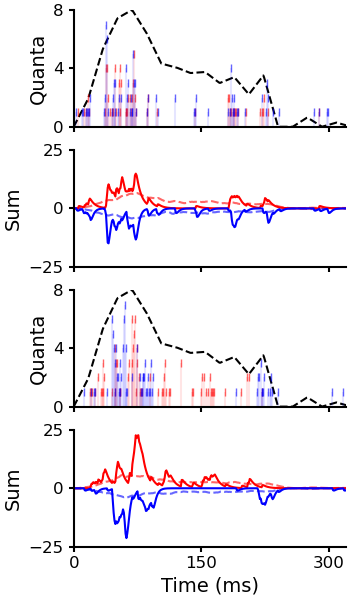

In [23]:
tr = 0  # trial to display (94 with null?)
incl_template = True
scale_template = True
incl_rate = False
sum_vmax = 25
rate_alpha = 0.5
stem_alpha = 0.1
stem_marker = "|"
mark_alpha = 0.6
circle_marks = False
lbl_sz = 14

n_cols = 1 + int(show_null)
template_mul = max_quanta if scale_template else 1

psn_rate_qsum_grid_fig, psn_rate_qsum_grid_ax = plt.subplots(
    4, n_cols, sharex="col", sharey="row", figsize=(6 if show_null else 3.5, 6))
psn_rate_qsum_grid_ax = (np.expand_dims(psn_rate_qsum_grid_ax, 1) 
                             if n_cols == 1 else psn_rate_qsum_grid_ax)

for d in range(n_cols):
    for r in range(2):
        if incl_template:
            psn_rate_qsum_grid_ax[r * 2, d].plot(
                vrate_xaxis, norm_rate * template_mul, c="black", ls="--", label="iGluSnFR Template")
        if incl_rate:
            psn_rate_qsum_grid_ax[r * 2, d].plot(
                vrate_xaxis, np.clip(rates[d, r, tr, 0], 0, None),
                alpha=rate_alpha, c="blue", label="AR(p) ACh Rate"
            )
            psn_rate_qsum_grid_ax[r * 2, d].plot(
                vrate_xaxis, np.clip(rates[d, r, tr, 1], 0, None),
                alpha=rate_alpha, c="red", label="AR(p) GABA Rate"
            )

        gaba_psn_marks, gaba_psn_stems, _ = psn_rate_qsum_grid_ax[r * 2, d].stem(
            vrate_xaxis,
            [n if n else np.nan for n in psns[d, r, tr, 1]],
            linefmt="-",
            markerfmt=("r%s" % stem_marker) if stem_marker != "none" else "none",
            basefmt="none",
            label="Poisson Quanta",
        )
        if circle_marks:
            gaba_psn_marks.set_marker("o")
            gaba_psn_marks.set_markerfacecolor("none")
            gaba_psn_marks.set_markersize(3)
        gaba_psn_marks.set_alpha(mark_alpha)
        gaba_psn_stems.set_alpha(stem_alpha)
        gaba_psn_stems.set_color("red")
        
        ach_psn_marks, ach_psn_stems, _ = psn_rate_qsum_grid_ax[r * 2, d].stem(
            vrate_xaxis,
            [n if n else np.nan for n in psns[d, r, tr, 0]],
            linefmt="-",
            markerfmt=("b%s" % stem_marker) if stem_marker != "none" else "none",
            basefmt="none",
            label="Poisson Quanta",
        )
        if circle_marks:
            ach_psn_marks.set_marker("o")
            ach_psn_marks.set_markersize(3)
            ach_psn_marks.set_markerfacecolor("none")
        ach_psn_marks.set_alpha(mark_alpha)
        ach_psn_stems.set_alpha(stem_alpha)
        ach_psn_stems.set_color("blue")

        psn_rate_qsum_grid_ax[r * 2 + 1, d].plot(qsum_xaxis, avg_qsum_recs[d, r, 1], c="red", lw=1.5, alpha=0.6, linestyle="--")
        psn_rate_qsum_grid_ax[r * 2 + 1, d].plot(qsum_xaxis, avg_qsum_recs[d, r, 0], c="blue", lw=1.5, alpha=0.6, linestyle="--")
        psn_rate_qsum_grid_ax[r * 2 + 1, d].plot(qsum_xaxis, qsum_recs[d, r, tr, 1], c="red", lw=1.5)
        psn_rate_qsum_grid_ax[r * 2 + 1, d].plot(qsum_xaxis, qsum_recs[d, r, tr, 0], c="blue", lw=1.5)

qticks = [0, 5, 10] if show_null else [0, 4, 8]
for r in range(2):     
    psn_rate_qsum_grid_ax[r * 2, 0].set_yticks(qticks)
    psn_rate_qsum_grid_ax[r * 2, 0].set_ylim(0, np.max(qticks))
    psn_rate_qsum_grid_ax[r * 2, 0].set_ylabel("Quanta", fontsize=lbl_sz)
    psn_rate_qsum_grid_ax[r * 2 + 1, 0].set_yticks([-sum_vmax, 0, sum_vmax])
    psn_rate_qsum_grid_ax[r * 2 + 1, 0].set_ylabel("Sum", fontsize=lbl_sz)

for d in range(n_cols):
    psn_rate_qsum_grid_ax[-1, d].set_xlim(0, 320)
    psn_rate_qsum_grid_ax[-1, d].set_xticks([0, 150, 300])
    psn_rate_qsum_grid_ax[-1, d].set_xlabel("Time (ms)", fontsize=lbl_sz)

if show_null:
    psn_rate_qsum_grid_ax[0, 0].set_title("Preferred", fontsize=16)
    psn_rate_qsum_grid_ax[0, 1].set_title("Null", fontsize=16)

# dummy_yaxis_label(psn_rate_qsum_grid_ax[0, 0], "Corelease")
# dummy_yaxis_label(psn_rate_qsum_grid_ax[2, 0], "Uncorrelated")

clean_axes(psn_rate_qsum_grid_ax,ticksize=12, spine_width=1.5)
psn_rate_qsum_grid_fig.set_layout_engine("compressed")

rho_lbl = str(corr_ei_rho) + "_" + str(uncorr_ei_rho)
tags = []
if incl_rate: tags.append("rate")
if incl_template: tags.append(("scaled" if scale_template else "") + "template")
if show_null: tags.append("null")
tag_lbl = ("_with_" + "_and_".join(tags)) if len(tags) > 0 else ""
for ext in [".png", ".svg"]:
    psn_rate_qsum_grid_fig.savefig(
        os.path.join(fig_path, "ach_gaba_psn%s_qsum_grid_rho%s_seed%i_trial%iof%i%s" % (
            tag_lbl, rho_lbl, seed, tr, n_trials, ext)), bbox_inches="tight")

In [24]:
max_rho = 0.95
min_rho = 0
delta_to_rho = np.vectorize(
    lambda d: max_rho - (max_rho - min_rho) * d / 180
)


ts = np.array([[10, 60, 0]])
ds = np.vectorize(wrap_180)(ts - ts.T)
rs = delta_to_rho(ds)
rs = np.repeat(np.expand_dims(rs, 0), 3, axis=0)
rs[:, np.diag_indices(3, 1), np.diag_indices(3, 1)] = 1
rs

array([[[1.        , 0.68611111, 0.89722222],
        [0.68611111, 1.        , 0.63333333],
        [0.89722222, 0.63333333, 1.        ]],

       [[1.        , 0.68611111, 0.89722222],
        [0.68611111, 1.        , 0.63333333],
        [0.89722222, 0.63333333, 1.        ]],

       [[1.        , 0.68611111, 0.89722222],
        [0.68611111, 1.        , 0.63333333],
        [0.89722222, 0.63333333, 1.        ]]])